In [1]:
import torch
import sys

sys.path.append('..')

import SourceCode

In [2]:
from math import pi, e, sin
import torch
from SourceCode.utilities import nth_derivative, plot_two_curves
from SourceCode.EquationClass import MainEquationClass
from SourceCode.DomainClass import OneDimensionalSimpleDomain
from SourceCode.InitConditionClass import OnePointInitialCondition
from SourceCode.TrainerForNNEquationSolver import TrainerForNNEquationSolver
from SourceCode.ReportMaker import ReportMaker
import time


n_epochs = 10
n_points = 10
dh = 1e-3

# №0.1

$$ x'= -y $$
$$ y' = x + cost(t) $$
$$ x(0) = 0$$ $$y(0) = 0$$
$$t \in [0,1] $$
True_solution: $$x = -\frac{1}{2}tsin(t)$$ $$y = tcos(t) + \frac{1}{2}sin(t)$$

In [4]:
left_bound = 0
right_bound = 1
main_eq_residual1 = lambda t, x, y: nth_derivative(x(t), t, 1) + y(t)
main_eq_residual2 = lambda t, x, y: nth_derivative(y(t), t, 1) - x(t) - torch.cos(t)
main_eq_residuals = [main_eq_residual1, main_eq_residual2]
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_bound + dh, 
                                         right_bound, 
                                         n_points)


first_init_cond_res = lambda x, nn_model1, nn_model2: nn_model1(x) - 0
first_init_cond = OnePointInitialCondition(left_bound, 
                                           first_init_cond_res)

second_init_cond_res = lambda x, nn_model1, nn_model2: nn_model2(x) - 0
second_init_cond = OnePointInitialCondition(left_bound, 
                                            second_init_cond_res)

boundary_conditions = [first_init_cond, second_init_cond]

main_eq = MainEquationClass(main_domain, 
                                     main_eq_residuals, 
                                     boundary_conditions)


nn_ode_solver = TrainerForNNEquationSolver(main_eq)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()

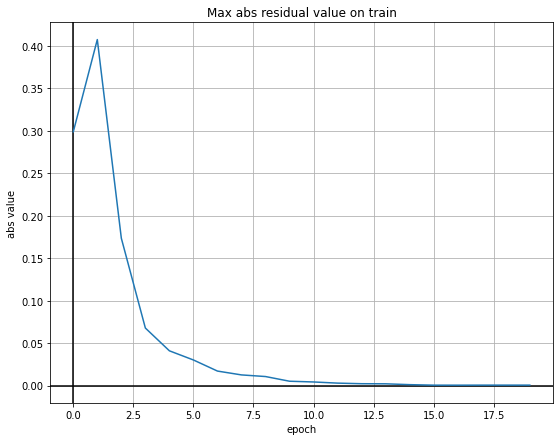

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 3.099587047472596e-05
Valid max absolute error |Appr(x)-y(x)|: 3.12233496515546e-05
MAPE on train data: 0.00339670259563718 %
MAPE on validation data: 0.0034660894016269594 %
Max abs value of residual on train at last epoch: 0.0004379749298095703 


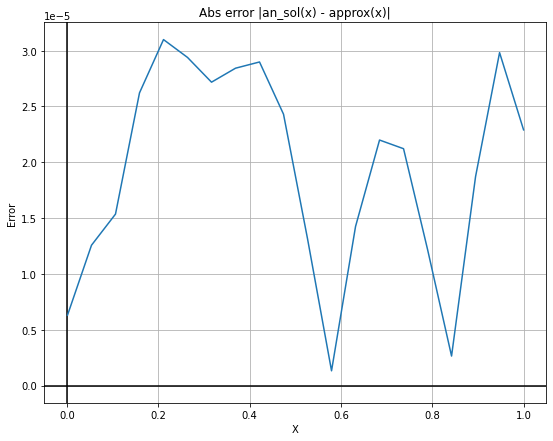

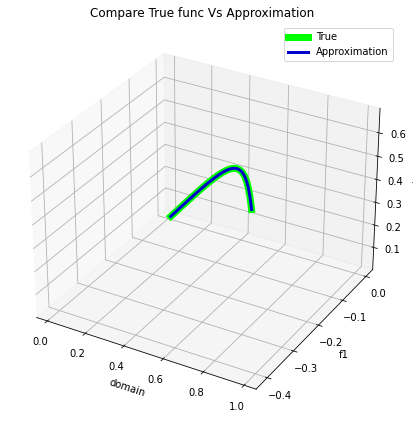

In [5]:
analytical_solution1 = lambda x: -1/2 * x * torch.sin(x)
analytical_solution2 = lambda x: 1/2*(x*torch.cos(x) + torch.sin(x))
analytical_solutions = [analytical_solution1, analytical_solution2]

report = ReportMaker(nn_models,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_curves,
                         analytical_solutions=analytical_solutions
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

# № 0.2 #

$$ x'= -y $$
$$ y' = x + cost(t) $$
$$ x(0) = 0$$ $$y(0) = 0$$
$$t \in [0,5] $$
True_solution: $$x = -\frac{1}{2}tsin(t)$$ $$y = tcos(t) + \frac{1}{2}sin(t)$$
Approximation satisfying boundary conditions: $$ apprX(t) = t*nn_1(t) $$
$$ apprY(t) = t*nn_2(t) $$

In [6]:
left_bound = 0
right_bound = 5
main_eq_residual1 = lambda t, x, y: nth_derivative(x(t), t, 1) + y(t)
main_eq_residual2 = lambda t, x, y: nth_derivative(y(t), t, 1) - x(t) - torch.cos(t)
main_eq_residuals = [main_eq_residual1, main_eq_residual2]
n_points = 20

dh = 0.001
main_domain = OneDimensionalSimpleDomain(left_bound + dh, right_bound, n_points)

main_eq = MainEquationClass(main_domain, main_eq_residuals)
boundary_satisfying_models = [
        lambda x, model1: x * model1(x),
        lambda x, model2: x * model2(x)
    ]

n_epochs = 20
nn_ode_solver = TrainerForNNEquationSolver(main_eq,
                                               n_epochs=n_epochs,
                                               act_func=torch.tanh,
                                               boundary_satisfying_models=boundary_satisfying_models)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()


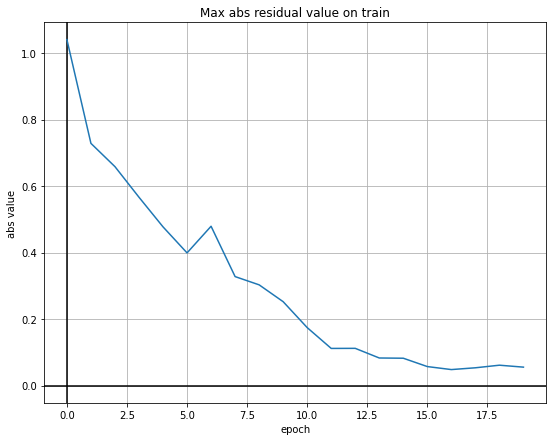

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.023195505142211914
Valid max absolute error |Appr(x)-y(x)|: 0.024799328297376633
MAPE on train data: 0.6411000154912472 %
MAPE on validation data: 0.6594418082386255 %
Max abs value of residual on train at last epoch: 0.0552295446395874 


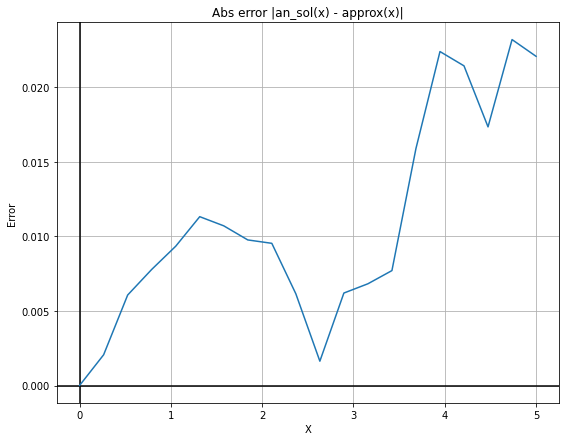

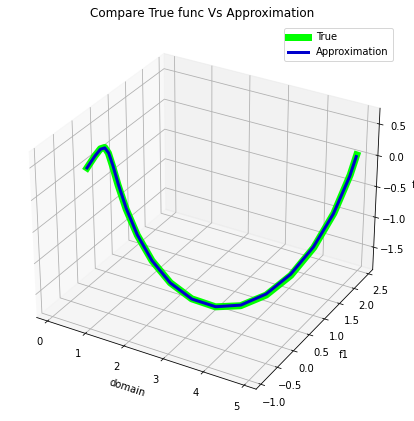

In [7]:
analytical_solution1 = lambda x: -1 / 2 * x * torch.sin(x)
analytical_solution2 = lambda x: 1 / 2 * (x * torch.cos(x) + torch.sin(x))
analytical_solutions = [analytical_solution1, analytical_solution2]
report = ReportMaker(nn_models,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_curves,
                         analytical_solutions=analytical_solutions
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

# № 1

$$ D^{0.5}y_1 = x^{0.5}cos(x)+y_1+y_2 -(e^x+sin(x)) $$
$$ D^{0.75}y_2 = x^{0.25}e^x+y_1-sin(x) $$
$$ <=> $$
$$ x^{0.5}y_1'(x)= x^{0.5}cos(x)+y_1+y_2 -(e^x+sin(x))$$
$$ x^{0.25}y_2'(x) = x^{0.25}e^x+y_1-sin(x) $$
$$ y_1(0) = 0$$ $$y_2(0) = 1$$
$$x \in [0,1] $$
True_solution: $$y_1 = sin(x)$$ $$y_2 = e^x$$

In [9]:
left_bound = 0
right_bound = 1
main_eq_residual1 = lambda x, y1, y2: (torch.pow(x,0.5)*nth_derivative(y1(x), x, 1)
                                       -x**(0.5)*torch.cos(x)
                                       - y1(x)-y2(x) + torch.exp(x) + torch.sin(x))
main_eq_residual2 = lambda x, y1, y2: (x**(0.25)*nth_derivative(y2(x), x, 1) - 
                                       pow(x,0.25)*torch.exp(x)
                                      -y1(x) + torch.sin(x))
main_eq_residuals = [main_eq_residual1, main_eq_residual2]
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_bound + dh, 
                                         right_bound, 
                                         n_points)


first_init_cond_res = lambda x, nn_model1, nn_model2: nn_model1(x)
first_init_cond = OnePointInitialCondition(left_bound, first_init_cond_res)

second_init_cond_res = lambda x, nn_model1, nn_model2: (nn_model2(x) 
                                                        - torch.tensor([1.0], requires_grad=True))
second_init_cond = OnePointInitialCondition(left_bound, second_init_cond_res)

boundary_conditions = [first_init_cond, second_init_cond]

main_eq = MainEquationClass(main_domain, main_eq_residuals, boundary_conditions)

n_epochs = 20
nn_ode_solver = TrainerForNNEquationSolver(main_eq, n_epochs=n_epochs, act_func = torch.tanh)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()

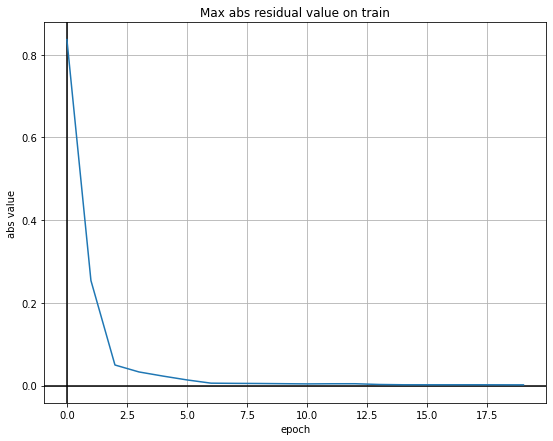

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.01327759213745594
Valid max absolute error |Appr(x)-y(x)|: 0.012992647476494312
MAPE on train data: 0.2732922323048115 %
MAPE on validation data: 0.2760954899713397 %
Max abs value of residual on train at last epoch: 0.0015575885772705078 


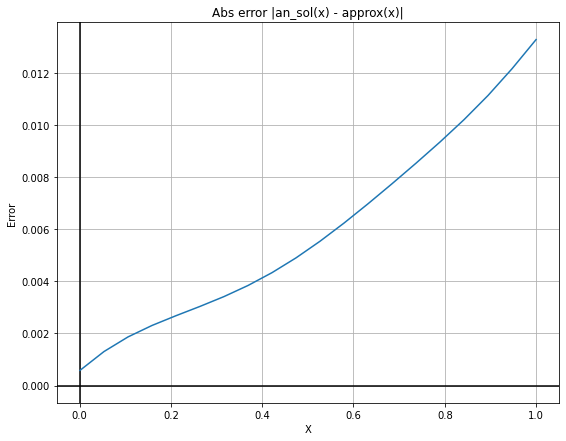

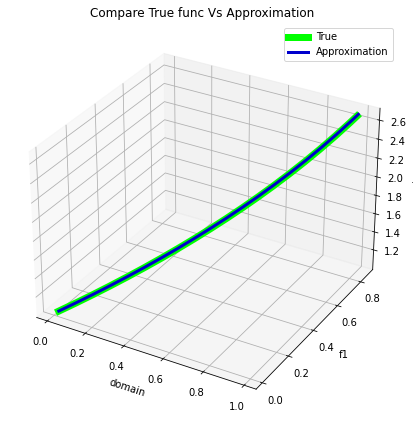

In [10]:
analytical_solution1 = lambda x: torch.sin(x)
analytical_solution2 = lambda x: torch.exp(x)
analytical_solutions = [analytical_solution1, analytical_solution2]
report = ReportMaker(nn_models,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_curves,
                         analytical_solutions=analytical_solutions
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

In [11]:
report.print_comparison_table()

train data
       Input  Analytical_x1    ANN_x1  Analytical_x2    ANN_x2     Error
0   0.001000       0.001000  0.001578       1.001001  1.001053  0.000581
1   0.053579       0.053553  0.054776       1.055040  1.055490  0.001303
2   0.106158       0.105959  0.107693       1.111997  1.112682  0.001864
3   0.158737       0.158071  0.160223       1.172029  1.172854  0.002304
4   0.211316       0.209747  0.212260       1.235302  1.236231  0.002679
5   0.263895       0.260842  0.263695       1.301991  1.303032  0.003036
6   0.316474       0.311217  0.314416       1.372280  1.373472  0.003413
7   0.369053       0.360732  0.364307       1.446364  1.447763  0.003839
8   0.421632       0.409250  0.413247       1.524447  1.526115  0.004332
9   0.474211       0.456636  0.461112       1.606745  1.608737  0.004899
10  0.526789       0.502761  0.507772       1.693487  1.695842  0.005537
11  0.579368       0.547496  0.553097       1.784911  1.787649  0.006235
12  0.631947       0.590717  0.596955   